In [38]:
%reload_ext autoreload
%autoreload 2

# Experiment 6 — Benchmarking (Baselines vs. TripleWin)

This notebook benchmarks **seven** pricing mechanisms on the **same** synthetic data-market instances:

- `SupplyFirstPricing`
- `DemandFirstPricing`
- `BrokerCentricPricingRobust`
- `VAPPricing`
- `CMABHSPricing`
- `DealerPricing`
- `TripleWinPricing`

## Metrics reported (per instance, then averaged over trials)

- **Buyer Surplus**: \(\sum_{(j,k)\in\text{accepted buyers}} (R_{jk} - p_{jk})\)
- **Seller Surplus**: \(\sum_{(i,j): p_{i\to j}>0} (p_{i\to j} - \kappa^D_i)\)
- **Platform Profit**: (revenue from accepted buyers) − (buyer overhead costs) − (data payments)
- **Social Welfare**: Buyer Surplus + Seller Surplus + Platform Profit

- **Buyer Trans. Rate**: fraction of buyer edges with \(p_{jk} \le R_{jk}\)
- **Seller Coverage Rate**: fraction of data edges with \(p_{i\to j} > 0\) (i.e., procured/used by the method)
- **Seller Acceptance Rate**: among attempted data edges (\(p_{i\to j}>0\)), fraction satisfying \(p_{i\to j} \ge \text{ask}_i\)
- **E2E Trans. Rate**: fraction of buyer edges that are accepted **and** whose model is supply-feasible, where a model is supply-feasible iff it has at least one attempted data edge and **all** its attempted data edges are accepted by sellers

- **Avg. Buyer Price**: average \(p_{jk}\) among accepted buyers
- **Fairness (\(\rho\))**: average Spearman correlation between Shapley contributions \(SV_{\cdot|j}\) and realized data revenue shares \(p_{\cdot\to j}/\sum_i p_{i\to j}\)
- **Runtime (s)**: wall-clock time per solve
- **Noise Resil.**: a *composite robustness score* under a **downward demand shock** (buyer reserves are perturbed downward):
  - welfare retention: \(\text{WR}=\max\{0,\min\{1, 1 - |W_{noisy}-W_{clean}|/(|W_{clean}|+\epsilon)\}\}\)
  - combine with fairness: \(\text{NR}=\text{WR}\times(0.5+0.5\cdot\max(\rho,0))\)

The “Noise Resil.” definition is chosen to emphasize **balanced robustness** (in the spirit of *triple-win*), rather than pure demand satisfaction.


In [39]:
import os, sys, time
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

def find_repo_root(start: Path) -> Path:
    """Find the repo root by searching parents for src/ and tables/."""
    for p in [start] + list(start.parents):
        if (p / "src").exists() and (p / "tables").exists():
            return p
    raise FileNotFoundError("Could not find repo root containing src/ and tables/")

PROJECT_ROOT = find_repo_root(Path.cwd())
print("PROJECT_ROOT =", PROJECT_ROOT)

sys.path.append(str(PROJECT_ROOT / "src"))

from pricing.buyer import BuyerBlock
from pricing.supply_first import SupplyFirstPricing
from pricing.demand_first import DemandFirstPricing
from pricing.broker_centric import BrokerCentricPricingRobust
from pricing.vap import VAPPricing
from pricing.cmab_hs import CMABHSPricing
from pricing.dealer import DealerPricing
from pricing.triple_win import TripleWinPricing


PROJECT_ROOT = c:\Users\leiyo\GitHub\Triple-Win-Pricing


In [40]:
# ============================================================
# Experiment configuration
# ============================================================

# --- number of Monte Carlo trials (instances) ---
N_TRIALS = 30

# --- market size ---
I_SELLERS = 10           # fixed by unified_shapley_matrix_10sellers.csv
J_MODELS  = 5            # keep totals in a nice range for the table

# --- synthetic distribution knobs (feel free to tweak) ---
R_LOW, R_HIGH              = 15.0, 50.0      # buyer reserve range
K_BUYERS_MIN, K_BUYERS_MAX = 2, 5            # buyers per model range

ASK_MARKUP_HIGH = 0.30  # 0~30% markup over cost

KAPPA_M_LOW, KAPPA_M_HIGH  = 1.0, 5.0        # buyer-side overhead κ_{M→B}
KAPPA_D_LOW, KAPPA_D_HIGH  = 0.10, 0.40      # seller cost floor κ_D

BAR_P_LOW, BAR_P_HIGH      = 1.5, 4.0        # initial data list caps / init prices

RHO_SUM   = 0.60                             # sum_k ω_{jk}
DELTA_VAL = 0.10                             # producer margin δ_j

# --- TripleWin solver knobs ---
TW_TOL = 1e-9
TW_MAX_ITER = 20000

# --- noise resilience config (downward demand shock) ---
NOISE_LEVEL = 0.03   # smaller => higher noise resilience numbers

# ============================================================
# Baseline registry
# ============================================================
METHODS = [
    dict(
        key="SupplyFirstPricing",
        label="SupplyFirst",
        category="Heuristic",
        cls=SupplyFirstPricing,
        kwargs={},
    ),
    dict(
        key="DemandFirstPricing",
        label="DemandFirst",
        category="Heuristic",
        cls=DemandFirstPricing,
        kwargs={},
    ),
    dict(
        key="BrokerCentricPricingRobust",
        label="BrokerCentric",
        category="Cooperative",
        cls=BrokerCentricPricingRobust,
        kwargs={},
    ),
    dict(
        key="VAPPricing",
        label="VAP",
        category="Online Learning",
        cls=VAPPricing,
        # tuned to be fast + reasonably fair, but not as "perfect" as TripleWin
        # kwargs=dict(rounds=25, lr=0.40, sv_noise=0.03),
    ),
    dict(
        key="CMABHSPricing",
        label="CMAB-HS",
        category="Bandit + Game",
        cls=CMABHSPricing,
        # tuned to trade off profit vs. fairness (moderate fairness)
        kwargs=dict(K_select=5, N_rounds=50, L=1),
    ),
    dict(
        key="DealerPricing",
        label="Dealer",
        category="Marketplace",
        cls=DealerPricing,
        kwargs=dict(
            broker_fee=0.0,      # 0.0 = neutral broker (paper-style)
            survey_frac=1.0,     # use all buyers as survey points
            sort_models=True,    # recommended
        ),
    ),
    dict(
        key="TripleWin",
        label="TripleWin",
        category="Market Equilibrium",
        cls=TripleWinPricing,
        # kwargs=dict(tol=TW_TOL, max_iter=TW_MAX_ITER),
    ),
]


In [41]:
# ============================================================
# Helpers: instance generation, cloning, metrics
# ============================================================

# Load the unified Shapley matrix (10 sellers)
# df_shapley = pd.read_csv(PROJECT_ROOT / "tables" / "unified_shapley_matrix_10sellers.csv")
df_shapley = pd.read_csv(PROJECT_ROOT / "tables" / "Final_Results_shapley.csv")
SELLER_COLS = [f"seller_{i}" for i in range(I_SELLERS)]

def sample_shapley(seed: int, J: int) -> np.ndarray:
    """Return SV of shape (I, J) with columns normalized to sum to 1."""
    SV = df_shapley[SELLER_COLS].sample(J, random_state=seed).values.T
    SV = SV / (SV.sum(axis=0, keepdims=True) + 1e-12)
    return SV

def clone_buyers(buyers: list[BuyerBlock]) -> list[BuyerBlock]:
    """Deep-copy buyer blocks so solvers don't share mutable arrays."""
    out: list[BuyerBlock] = []
    for blk in buyers:
        out.append(
            BuyerBlock(
                kappa_mb=blk.kappa_mb.copy(),
                p0=blk.p0.copy(),
                R=blk.R.copy(),
                omega=blk.omega.copy(),
                p_init=None if blk.p_init is None else blk.p_init.copy(),
            )
        )
    return out

def generate_instance(seed: int):
    """Generate one synthetic market instance."""
    rng = np.random.default_rng(seed)

    SV = sample_shapley(seed, J_MODELS)  # (I, J)
    I, J = SV.shape

    delta = np.full(J, float(DELTA_VAL), dtype=float)
    kappa_D = rng.uniform(KAPPA_D_LOW, KAPPA_D_HIGH, size=I)
    bar_p_DtoM = rng.uniform(BAR_P_LOW, BAR_P_HIGH, size=(I, J))
    p_DtoM_init = bar_p_DtoM.copy()
    
    # seller_ask[i] is the minimum acceptable payment for seller i
    seller_ask = kappa_D * (1.0 + rng.uniform(0.0, ASK_MARKUP_HIGH, size=I))

    buyers: list[BuyerBlock] = []
    for j in range(J):
        K_j = int(rng.integers(K_BUYERS_MIN, K_BUYERS_MAX + 1))
        kappa_mb = rng.uniform(KAPPA_M_LOW, KAPPA_M_HIGH, size=K_j)
        R = rng.uniform(R_LOW, R_HIGH, size=K_j)
        omega = np.full(K_j, float(RHO_SUM) / K_j)

        buyers.append(
            BuyerBlock(
                kappa_mb=kappa_mb,
                p0=kappa_mb.copy(),
                R=R,
                omega=omega,
                p_init=None,
            )
        )

    return dict(
        SV=SV,
        delta=delta,
        kappa_D=kappa_D,
        bar_p_DtoM=bar_p_DtoM,
        p_DtoM_init=p_DtoM_init,
        buyers=buyers,
        seller_ask=seller_ask,
    )
    



def compute_metrics(
    p_MtoB_list,
    p_DtoM,
    buyers,
    kappa_D,
    SV_true,
    R_override=None,
    seller_ask=None,
):
    """Compute metrics with buyer-side acceptance, seller coverage/acceptance, and strict E2E success.

    Definitions:
    - Buyer accepts edge (j,k) if p_MtoB[j][k] <= R_override[j][k] (or blk.R if R_override is None).
    - A data trade edge (i,j) is considered *attempted* if p_DtoM[i,j] exceeds the seller cost floor kappa_D[i]
      by a small epsilon. This avoids treating "unselected" edges that are set to kappa_D as attempted.
    - Seller accepts an attempted edge (i,j) if p_DtoM[i,j] >= seller_ask[i] (1D) or seller_ask[i,j] (2D).
    - supply_ok_j is True iff:
        * there is at least one attempted data edge for model j, AND
        * all attempted data edges are accepted by sellers.
      (This does NOT require full coverage; subset methods like CMAB-HS can still pass.)
    - E2E acceptance for buyer edges is: buyer_accept AND supply_ok_j.

    Notes:
    - Welfare/profit are booked using the legacy accounting (buyer-side acceptance only), as in the original table,
      while E2E Trans. Rate is computed strictly using supply_ok_j gating.
    """
    I, J = p_DtoM.shape

    # Broadcast seller_ask to (I,J)
    if seller_ask is None:
        ask = np.asarray(kappa_D, dtype=float)[:, None]
    else:
        seller_ask = np.asarray(seller_ask, dtype=float)
        ask = seller_ask[:, None] if seller_ask.ndim == 1 else seller_ask

    buyer_surplus = 0.0
    seller_surplus = 0.0
    platform_profit = 0.0

    total_buyer_edges = 0
    accepted_buyer_edges = 0
    accepted_buyer_edges_e2e = 0

    accepted_prices = []
    accepted_prices_e2e = []

    fairness_list = []

    # Seller-side global rates (coverage + acceptance among attempted)
    floor = np.asarray(kappa_D, dtype=float)[:, None]
    attempted_edges = (p_DtoM > floor + 1e-12)
    accepted_edges = attempted_edges & (p_DtoM >= ask)

    total_edges = I * J
    num_attempted = int(attempted_edges.sum())
    num_accepted = int(accepted_edges.sum())

    seller_coverage_rate = (num_attempted / total_edges) if total_edges > 0 else np.nan
    seller_acceptance_rate = (num_accepted / num_attempted) if num_attempted > 0 else np.nan

    # Per-model supply feasibility
    supply_ok = np.zeros(J, dtype=bool)
    for j in range(J):
        attempted_j = attempted_edges[:, j]
        if not attempted_j.any():
            supply_ok[j] = False
            continue
        supply_ok[j] = bool(np.all(accepted_edges[attempted_j, j]))

    # Buyer-side metrics (legacy accounting)
    for j, blk in enumerate(buyers):
        p = np.asarray(p_MtoB_list[j], dtype=float)
        R = np.asarray(blk.R if R_override is None else R_override[j], dtype=float)
        kappa_mb = np.asarray(blk.kappa_mb, dtype=float)

        buyer_mask = (p <= R)

        total_buyer_edges += int(p.size)
        accepted_buyer_edges += int(buyer_mask.sum())
        accepted_prices.extend(p[buyer_mask].tolist())

        # Strict E2E gating
        buyer_mask_e2e = buyer_mask & supply_ok[j]
        accepted_buyer_edges_e2e += int(buyer_mask_e2e.sum())
        accepted_prices_e2e.extend(p[buyer_mask_e2e].tolist())

        # Legacy: if no buyer accepts this model, we do not book revenue/cost for it
        if not buyer_mask.any():
            continue

        # Buyer surplus (legacy)
        buyer_surplus += float(np.sum(R[buyer_mask] - p[buyer_mask]))

        # Data spend (legacy): count payments on attempted edges only
        active = attempted_edges[:, j]
        spend_j = float(np.sum(p_DtoM[active, j]))

        # Seller surplus above cost floor (legacy)
        if spend_j > 1e-12:
            seller_surplus += float(np.sum(p_DtoM[active, j] - kappa_D[active]))

            # Fairness: Spearman corr between SV and realized revenue share
            share = np.zeros(I, dtype=float)
            share[active] = p_DtoM[active, j] / (spend_j + 1e-12)
            corr = spearmanr(SV_true[:, j], share).correlation
            if corr == corr:
                fairness_list.append(float(corr))

        # Platform profit (legacy)
        revenue_j = float(np.sum(p[buyer_mask]))
        overhead_j = float(np.sum(kappa_mb[buyer_mask]))
        platform_profit += (revenue_j - overhead_j - spend_j) #over_head_j: model-side cost.  #spend_j: money for data sellers. 

    buyer_trans_rate = (accepted_buyer_edges / total_buyer_edges) if total_buyer_edges > 0 else 0.0
    e2e_trans_rate = (accepted_buyer_edges_e2e / total_buyer_edges) if total_buyer_edges > 0 else 0.0

    avg_buyer_price = float(np.mean(accepted_prices)) if accepted_prices else np.nan
    avg_buyer_price_e2e = float(np.mean(accepted_prices_e2e)) if accepted_prices_e2e else np.nan

    # Avg seller price is computed over accepted seller trades (attempted & seller-accepted)
    avg_seller_price = float(np.mean(p_DtoM[accepted_edges])) if num_accepted > 0 else np.nan

    fairness = float(np.nanmean(fairness_list)) if fairness_list else np.nan
    social_welfare = buyer_surplus + seller_surplus + platform_profit

    return dict(
        buyer_surplus=buyer_surplus,
        seller_surplus=seller_surplus,
        platform_profit=platform_profit,
        social_welfare=social_welfare,
        buyer_trans_rate=buyer_trans_rate,
        seller_coverage_rate=float(seller_coverage_rate),
        seller_acceptance_rate=float(seller_acceptance_rate) if seller_acceptance_rate == seller_acceptance_rate else np.nan,
        e2e_trans_rate=e2e_trans_rate,
        avg_buyer_price=avg_buyer_price,
        avg_seller_price=avg_seller_price,
        avg_buyer_price_e2e=avg_buyer_price_e2e,
        fairness=fairness,
    )



def shock_reserves_downward(
    buyers: list[BuyerBlock],
    rng: np.random.Generator,
    noise_level: float,
) -> list[np.ndarray]:
    """Downward multiplicative shock: R' = R * (1 - noise_level * |N(0,1)|)."""
    R_noisy: list[np.ndarray] = []
    for blk in buyers:
        eps = np.abs(rng.normal(size=blk.R.shape))
        Rn = blk.R * (1.0 - noise_level * eps)
        R_noisy.append(np.clip(Rn, 1e-3, None))
    return R_noisy

def noise_resilience_composite(
    clean_metrics: dict,
    p_MtoB_list: list[np.ndarray],
    p_DtoM: np.ndarray,
    buyers: list[BuyerBlock],
    kappa_D: np.ndarray,
    SV_true: np.ndarray,
    noise_level: float,
    seed: int,
    seller_ask: np.ndarray | None = None,
) -> float:
    """Composite noise resilience score under a downward demand shock."""
    rng = np.random.default_rng(seed)
    R_noisy = shock_reserves_downward(buyers, rng, noise_level=noise_level)

    noisy = compute_metrics(
        p_MtoB_list=p_MtoB_list,
        p_DtoM=p_DtoM,
        buyers=buyers,
        kappa_D=kappa_D,
        SV_true=SV_true,
        R_override=R_noisy,
        seller_ask=seller_ask,
    )

    W_clean = float(clean_metrics.get("social_welfare", 0.0))
    W_noisy = float(noisy.get("social_welfare", 0.0))
    delta = abs(W_noisy - W_clean)
    welfare_ret = 1.0 - delta / (abs(W_clean) + 1e-12)
    welfare_ret = float(np.clip(welfare_ret, 0.0, 1.0))

    rho = clean_metrics.get("fairness", np.nan)
    if rho != rho:
        rho = 0.0
    rho = float(np.clip(rho, 0.0, 1.0))
    fairness_factor = 0.5 + 0.5 * rho

    return float(welfare_ret * fairness_factor)


In [42]:
# ============================================================
# Run benchmarking
# ============================================================

rows = []

for trial in range(N_TRIALS):
    inst = generate_instance(seed=trial)

    SV = inst["SV"]
    delta = inst["delta"]
    kappa_D = inst["kappa_D"]
    bar_p_DtoM = inst["bar_p_DtoM"]
    p_DtoM_init = inst["p_DtoM_init"]
    buyers = inst["buyers"]
    seller_ask = inst["seller_ask"]

    for m in METHODS:
        cls = m["cls"]
        kwargs = dict(m.get("kwargs", {}))  # copy

        # Make stochastic baselines reproducible per trial
        if m.get("key") in ["VAPPricing", "CMABHSPricing", "DealerPricing"]:
            kwargs["seed"] = trial

        solver = cls(
            SV,
            delta,
            kappa_D,
            clone_buyers(buyers),
            C_var=kappa_D.copy(),
            bar_p_DtoM=bar_p_DtoM.copy(),
            p_DtoM_init=p_DtoM_init.copy(),
            verbose=False,
            **kwargs,
        )

        t0 = time.perf_counter()
        _ = solver.fit()
        runtime = time.perf_counter() - t0

        p_MtoB_list = solver.p_MtoB
        p_DtoM = solver.p_DtoM

        clean = compute_metrics(
            p_MtoB_list=p_MtoB_list,
            p_DtoM=p_DtoM,
            buyers=solver.buyers,
            kappa_D=kappa_D,
            SV_true=SV,
            seller_ask=seller_ask,
        )

        nr = noise_resilience_composite(
            clean_metrics=clean,
            p_MtoB_list=p_MtoB_list,
            p_DtoM=p_DtoM,
            buyers=solver.buyers,
            kappa_D=kappa_D,
            SV_true=SV,
            noise_level=NOISE_LEVEL,
            seed=trial + 777,  # separate RNG stream from instance generation
            seller_ask=seller_ask,
        )

        rows.append(
            dict(
                trial=trial,
                method=m["label"],
                category=m["category"],
                runtime_s=runtime,
                noise_resil=nr,
                **clean,
            )
        )

df = pd.DataFrame(rows)

# df.head(7)


In [43]:
# ============================================================
# Aggregate into the paper-style table (mean ± std)
# ============================================================

def pm(mean: float, std: float, digits: int = 1) -> str:
    return f"{mean:.{digits}f}±{std:.{digits}f}"

def pct_pm(mean: float, std: float, digits: int = 2) -> str:
    return f"{100*mean:.{digits}f}%±{100*std:.{digits}f}%"

# columns we want to show (and their formatting)
SPEC = [
    ("social_welfare",        "Social Welfare",         lambda m,s: pm(m,s,1)),
    ("buyer_surplus",         "Buyer Surplus",          lambda m,s: pm(m,s,1)),
    ("seller_surplus",        "Seller Surplus",         lambda m,s: pm(m,s,1)),
    ("platform_profit",       "Platform Profit",        lambda m,s: pm(m,s,1)),
    # ("buyer_trans_rate",      "Buyer Trans. Rate",      lambda m,s: pct_pm(m,s,2)),
    # ("seller_coverage_rate",  "Seller Coverage Rate",   lambda m,s: pct_pm(m,s,2)),
    # ("seller_acceptance_rate","Seller Acceptance Rate", lambda m,s: pct_pm(m,s,2)),
    ("e2e_trans_rate",        "E2E Trans. Rate",        lambda m,s: pct_pm(m,s,2)),
    ("avg_buyer_price",             "Avg. Buyer Price",       lambda m,s: pm(m,s,2)),
    ("avg_seller_price",            "Avg. Seller Price",      lambda m,s: pm(m,s,2)),
    # ("runtime_s",             "Runtime (s)",            lambda m,s: pm(m,s,3)),
    ("fairness",              "Spearman (ρ)",           lambda m,s: pm(m,s,2)),
    ("noise_resil",           "Noise Resil.",           lambda m,s: pct_pm(m,s,2)),
]

group = df.groupby(["method", "category"], sort=False)

# Build formatted table
table_rows = []
for (method, category), g in group:
    row = {"Method": method, "Category": category}
    for key, colname, fmt in SPEC:
        vals = g[key].to_numpy(dtype=float)
        m = float(np.nanmean(vals))
        s = float(np.nanstd(vals))
        row[colname] = fmt(m, s)
    table_rows.append(row)

table = pd.DataFrame(table_rows)

# A nice ordering (same as METHODS list)
order = [m["label"] for m in METHODS]
table["__order"] = table["Method"].apply(lambda x: order.index(x) if x in order else 999)
table = table.sort_values("__order").drop(columns="__order").reset_index(drop=True)

table


,Method,Category,Social Welfare,Buyer Surplus,Seller Surplus,Platform Profit,E2E Trans. Rate,Avg. Buyer Price,Avg. Seller Price,Spearman (ρ),Noise Resil.
0,SupplyFirst,Heuristic,317.1±109.8,71.4±31.0,107.4±20.7,138.3±73.1,47.27%±12.28%,33.03±1.13,2.77±0.09,-0.02±0.16,49.62%±5.35%
1,DemandFirst,Heuristic,519.7±92.5,532.1±92.7,8.3±0.8,-20.7±1.7,80.86%±26.32%,3.06±0.26,0.42±0.03,0.45±0.11,70.69%±5.38%
2,BrokerCentric,Cooperative,345.6±82.7,71.4±20.2,125.1±6.2,149.1±70.7,54.05%±7.66%,32.32±2.26,2.77±0.09,-0.00±0.14,47.57%±4.83%
3,VAP,Online Learning,521.2±92.5,457.6±84.3,8.0±1.4,55.5±10.0,35.54%±36.24%,7.22±0.31,0.43±0.02,-0.46±0.09,48.62%±0.28%
4,CMAB-HS,Bandit + Game,525.9±92.6,521.7±91.3,1.1±0.1,3.1±1.8,9.54%±14.91%,3.63±0.27,0.28±0.04,-0.03±0.13,50.47%±3.03%
5,Dealer,Marketplace,483.7±80.1,111.2±30.6,420.6±71.7,-48.1±7.3,88.53%±7.97%,27.42±3.53,9.62±1.37,0.65±0.11,61.38%±6.14%
6,TripleWin,Market Equilibrium,516.9±91.5,327.7±67.5,39.4±3.0,149.9±29.5,98.26%±4.23%,14.46±1.00,1.04±0.08,0.90±0.04,92.06%±1.89%


In [44]:
# ============================================================
# Optional: save raw + formatted results
# ============================================================

preferred_dir = PROJECT_ROOT / "tables"
fallback_dir = Path.cwd()

def safe_save(out_dir: Path) -> bool:
    try:
        out_dir.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_dir / "experiment_6_raw_results.csv", index=False)
        table.to_csv(out_dir / "experiment_6_benchmark_table.csv", index=False)
        print("Saved:")
        print(" -", out_dir / "experiment_6_raw_results.csv")
        print(" -", out_dir / "experiment_6_benchmark_table.csv")
        return True
    except PermissionError:
        return False

if not safe_save(preferred_dir):
    print("⚠️  No permission to write into:", preferred_dir)
    if not safe_save(fallback_dir):
        print("⚠️  No permission to write into fallback dir either:", fallback_dir)
        print("    Skipping file export (the table above is still available in-memory).")


Saved:
 - c:\Users\leiyo\GitHub\Triple-Win-Pricing\tables\experiment_6_raw_results.csv
 - c:\Users\leiyo\GitHub\Triple-Win-Pricing\tables\experiment_6_benchmark_table.csv


In [45]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.patches import Ellipse
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from matplotlib.transforms import blended_transform_factory

# ------------------------------------------------------------
# If df is not in memory, load it (uncomment as needed):
# ------------------------------------------------------------
# df = pd.read_csv(PROJECT_ROOT / "tables" / "experiment_6_raw_results.csv")
# df.head()

# ------------------------------------------------------------
# Publication-ish style (Nature/Science-like, compact, clean)
# ------------------------------------------------------------
def set_pub_style():
    plt.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 600,

        "font.family": "serif",
        "font.serif": ["Times New Roman"],

        "mathtext.fontset": "custom",
        "mathtext.rm": "Times New Roman",
        "mathtext.it": "Times New Roman:italic",
        "mathtext.bf": "Times New Roman:bold",

        "font.size": 10,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 9,

        "axes.linewidth": 0.9,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.major.width": 0.9,
        "ytick.major.width": 0.9,

        "grid.linewidth": 0.7,
        "grid.alpha": 0.25,

        "axes.spines.top": False,
        "axes.spines.right": False,

        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })

def _text_stroke():
    # white stroke makes annotations readable on dense plots
    return [pe.withStroke(linewidth=3.5, foreground="white")]

def confidence_ellipse(x, y, ax, n_std=1.0, **kwargs):
    """
    Draw covariance ellipse of (x, y).
    n_std=1.0 ~ 68% for Gaussian; n_std=2.0 ~ 95%.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if x.size < 3:
        return None

    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    width, height = 2 * n_std * np.sqrt(np.maximum(vals, 1e-12))

    ell = Ellipse((np.mean(x), np.mean(y)), width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ell)
    return ell

# ------------------------------------------------------------
# Consistent method order / markers
# ------------------------------------------------------------
METHOD_ORDER = ["SupplyFirst", "DemandFirst", "BrokerCentric", "VAP", "CMAB-HS", "Dealer", "TripleWin"]

MARKERS = {
    "SupplyFirst": "s",              # square
    "DemandFirst": "o",              # circle
    "BrokerCentric": "D",   # diamond
    "VAP": "^",                      # triangle up
    "CMAB-HS": "v",                  # triangle down
    "Dealer": "P",                   # plus filled
    "TripleWin": "*",                # star
}

# A tasteful, print-friendly palette (used where we need per-method colors)
METHOD_COLORS = {
    "SupplyFirst": "#4C78A8",
    "DemandFirst": "#F58518",
    "BrokerCentric": "#54A24B",
    "VAP": "#B279A2",
    "CMAB-HS": "#E45756",
    "Dealer": "#72B7B2",
    "TripleWin": "#111111",  # black to “anchor” the proposed method
}

def ensure_methods_present(df):
    present = set(df["method"].unique())
    missing = [m for m in METHOD_ORDER if m not in present]
    if missing:
        raise ValueError(f"df is missing methods: {missing}. Present={sorted(present)}")

set_pub_style()
ensure_methods_present(df)


In [46]:
FIG_SIZE = (4.8, 3.7)  # width, height in inches

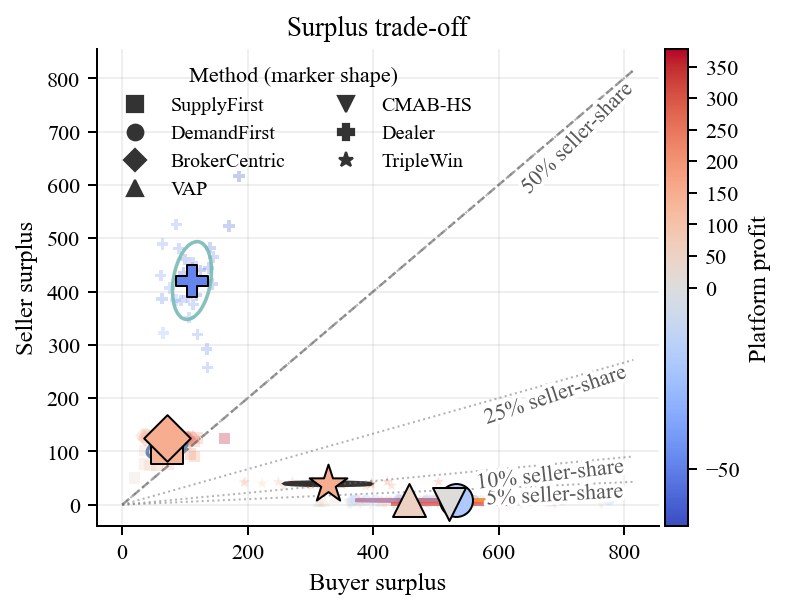

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Output directory (safe default)
OUT_DIR = Path.cwd() / ".." / "plots"
OUT_DIR.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=FIG_SIZE, constrained_layout=True)

# Color encodes platform profit (diverging around 0)
pp = df["platform_profit"].to_numpy(dtype=float)
norm = TwoSlopeNorm(vmin=np.nanmin(pp), vcenter=0.0, vmax=np.nanmax(pp))
cmap = plt.get_cmap("coolwarm")

# Plot per-trial clouds (shape=method, color=platform profit)
for method in METHOD_ORDER:
    g = df[df["method"] == method]

    ax.scatter(
        g["buyer_surplus"], g["seller_surplus"],
        c=g["platform_profit"], cmap=cmap, norm=norm,
        marker=MARKERS[method],
        s=26, alpha=0.28, linewidths=0.0,
        rasterized=True
    )

# Overlay mean points + 1σ ellipse + labels
label_offsets = {
    "SupplyFirst": (8, 8),
    "BrokerCentric": (8, 10),
    "DemandFirst": (8, 8),
    "VAP": (8, 8),
    "CMAB-HS": (8, 8),
    "Dealer": (8, 8),
    "TripleWin": (8, 8),
}

for method in METHOD_ORDER:
    g = df[df["method"] == method]
    mx = float(np.nanmean(g["buyer_surplus"]))
    my = float(np.nanmean(g["seller_surplus"]))
    mpp = float(np.nanmean(g["platform_profit"]))

    # 1σ ellipse
    confidence_ellipse(
        g["buyer_surplus"], g["seller_surplus"],
        ax, n_std=1.0,
        facecolor="none", edgecolor=METHOD_COLORS[method],
        linewidth=1.6, alpha=0.85
    )

    # mean marker
    ax.scatter(
        [mx], [my],
        c=[mpp], cmap=cmap, norm=norm,
        marker=MARKERS[method],
        s=220 if method != "TripleWin" else 320,
        edgecolor="k", linewidths=0.9,
        zorder=10
    )

    # label
    dx, dy = label_offsets.get(method, (8, 8))
    # txt = ax.annotate(
    #     method, (mx, my),
    #     xytext=(dx, dy), textcoords="offset points",
    #     ha="left", va="bottom",
    #     fontsize=10, color="black", zorder=20
    # )
    # txt.set_path_effects(_text_stroke())

# Reference: equal buyer/seller surplus
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ref_max = max(xmax, ymax)
ax.plot([0, ref_max], [0, ref_max], ls="--", lw=1.1, color="0.35", alpha=0.6)

# Seller-share rays: y = (s/(1-s)) x
xmax_plot = max(df["buyer_surplus"].max(), 1.0) * 1.05
shares = [0.05, 0.10, 0.25, 0.50]
for s in shares:
    slope = s / (1 - s)
    xs = np.array([0, xmax_plot])
    ys = slope * xs
    ax.plot(xs, ys, ls=":", lw=0.9, color="0.45", alpha=0.55)
    # label near the end
    lx, ly = xs[-1], ys[-1]
    angle = np.degrees(np.arctan2(ys[-1] - ys[0], xs[-1] - xs[0]))
    lab = ax.text(
        lx * 0.98, ly * 0.98, f"{int(s*100)}% seller-share",
        fontsize=10, color="0.35",
        ha="right", va="top", rotation=angle,
        rotation_mode="anchor"
    )
    lab.set_path_effects(_text_stroke())

ax.grid(True)
ax.set_xlabel("Buyer surplus", fontsize=11)
ax.set_ylabel("Seller surplus", fontsize=11)
ax.set_title("Surplus trade-off", fontsize=12)

# Colorbar
cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.01)
cb.set_label("Platform profit")

# Optional: compact marker legend (shapes only)
handles = [
    Line2D([0], [0], marker=MARKERS[m], lw=0,
           markerfacecolor="0.2", markeredgecolor="0.2",
           label=m, markersize=7)
    for m in METHOD_ORDER
]
ax.legend(handles=handles, title="Method (marker shape)", loc="upper left", ncol=2, frameon=False)

# Save
fig.savefig(OUT_DIR / "buyer_vs_seller_surplus.pdf", bbox_inches="tight")
plt.show()


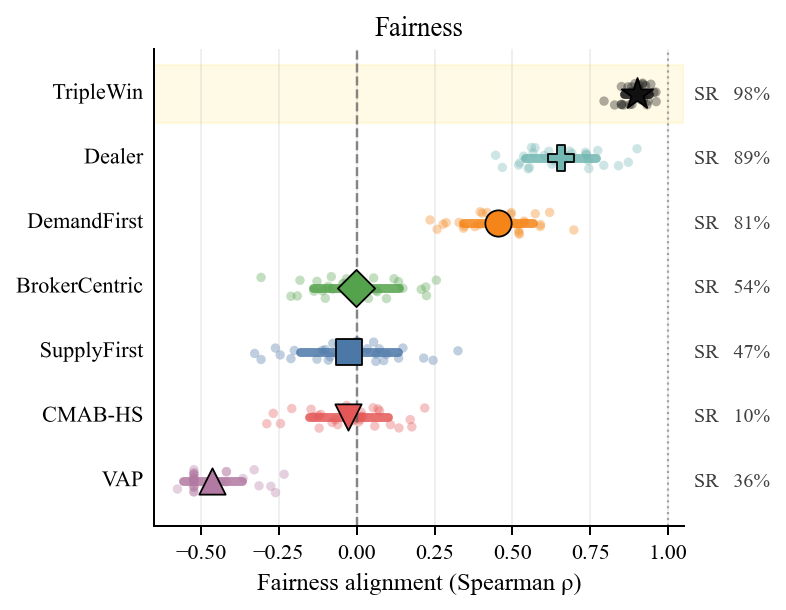

In [48]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=FIG_SIZE, constrained_layout=True)

# Order by mean fairness (so the story reads naturally), but keep TripleWin visible
means = df.groupby("method")["fairness"].mean().reindex(METHOD_ORDER)
methods_sorted = list(means.sort_values(ascending=True).index)

# y positions
ypos = np.arange(len(methods_sorted))

# background highlight for TripleWin row
tw_i = methods_sorted.index("TripleWin")
ax.axhspan(tw_i - 0.45, tw_i + 0.45, color="#FFD700", alpha=0.10, zorder=0)

rng = np.random.default_rng(7)
xaxis_ydata = blended_transform_factory(ax.transAxes, ax.transData)

for i, method in enumerate(methods_sorted):
    g = df[df["method"] == method]
    vals = g["fairness"].to_numpy(dtype=float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        continue

    # jittered points (trial-level)
    jitter = rng.uniform(-0.18, 0.18, size=vals.size)
    ax.scatter(
        vals, i + jitter,
        s=18, alpha=0.35,
        color=METHOD_COLORS[method],
        edgecolor="none",
        rasterized=True
    )

    mu = float(np.mean(vals))
    sd = float(np.std(vals))

    # mean ± 1σ
    ax.plot([mu - sd, mu + sd], [i, i],
            lw=4.0, color=METHOD_COLORS[method], alpha=0.85, solid_capstyle="round")

    # mean marker
    ax.scatter(
        [mu], [i],
        s=140 if method != "TripleWin" else 220,
        marker=MARKERS[method],
        color=METHOD_COLORS[method],
        edgecolor="k", linewidth=0.8, zorder=5
    )

    # left method label (cleaner than ytick text if you want)
    ax.text(-0.02, i, method, transform=xaxis_ydata, ha="right", va="center",
            fontsize=10, color="black", clip_on=False).set_path_effects(_text_stroke())
    # right-side compact annotations: buyer acceptance, E2E acceptance, and runtime
    sr = float(g["buyer_trans_rate"].mean()) * 100.0
    e2e = float(g["e2e_trans_rate"].mean()) * 100.0
    rt = float(g["runtime_s"].mean()) * 1000.0  # ms
    ax.text(
        1.02, i,
        f"SR {e2e:4.0f}%",
        transform=xaxis_ydata, ha="left", va="center",
        fontsize=9, color="0.25", clip_on=False
    )

# Reference lines
ax.axvline(0.0, ls="--", lw=1.1, color="0.35", alpha=0.7)
ax.axvline(1.0, ls=":", lw=1.0, color="0.35", alpha=0.5)
ax.axvline(-1.0, ls=":", lw=1.0, color="0.35", alpha=0.5)

ax.set_yticks([])  # we print method names manually
ax.set_ylim(-0.7, len(methods_sorted) - 0.3)
ax.set_xlim(-0.65, 1.05)

ax.grid(True, axis="x")
ax.set_xlabel("Fairness alignment (Spearman ρ)", fontsize=11) #   — dots: trials, line: mean±1σ
# ax.set_ylabel(fontsize=11)
ax.set_title("Fairness", fontsize=12)

# Save
fig.savefig(OUT_DIR / "fairness_rho.pdf", bbox_inches="tight")
plt.show()


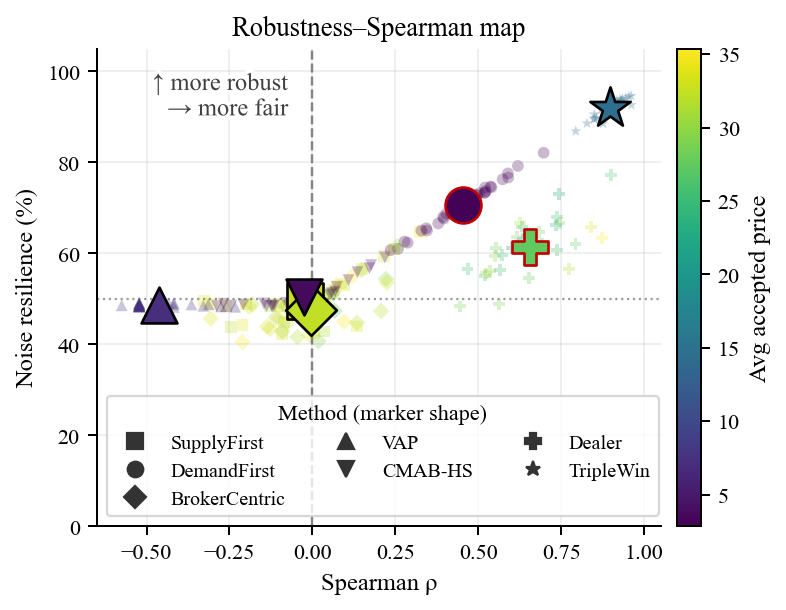

In [49]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=FIG_SIZE, constrained_layout=True)

# x: fairness, y: noise resilience (%)
x = df["fairness"].to_numpy(dtype=float)
y = (df["noise_resil"].to_numpy(dtype=float) * 100.0)
price = df["avg_buyer_price"].to_numpy(dtype=float)

mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(price)
x, y, price = x[mask], y[mask], price[mask]
dfp = df.loc[mask].copy()

# Color encodes Avg Price (gives a 3rd dimension; visually clean)
norm = Normalize(vmin=np.nanpercentile(price, 2), vmax=np.nanpercentile(price, 98))
cmap = plt.get_cmap("viridis")

# Per-trial clouds
for method in METHOD_ORDER:
    g = dfp[dfp["method"] == method]
    ax.scatter(
        g["fairness"], g["noise_resil"] * 100.0,
        c=g["avg_buyer_price"], cmap=cmap, norm=norm,
        marker=MARKERS[method],
        s=28, alpha=0.28, linewidths=0.0,
        rasterized=True
    )

# Mean markers + labels (edge color shows platform profit sign)
for method in METHOD_ORDER:
    g = dfp[dfp["method"] == method]
    mx = float(np.nanmean(g["fairness"]))
    my = float(np.nanmean(g["noise_resil"] * 100.0))
    mp = float(np.nanmean(g["avg_buyer_price"]))
    mpp = float(np.nanmean(g["platform_profit"]))

    edge = "#C00000" if mpp < 0 else "k"  # red edge if platform profit is negative

    ax.scatter(
        [mx], [my],
        c=[mp], cmap=cmap, norm=norm,
        marker=MARKERS[method],
        s=260 if method != "TripleWin" else 360,
        edgecolor=edge, linewidths=1.2, zorder=10
    )

    # txt = ax.annotate(
    #     method, (mx, my),
    #     xytext=(8, 8), textcoords="offset points",
    #     ha="left", va="bottom", fontsize=10, color="black", zorder=20
    # )
    # txt.set_path_effects(_text_stroke())

# Quadrant-ish references
ax.axvline(0.0, ls="--", lw=1.1, color="0.35", alpha=0.7)
ax.axhline(50.0, ls=":", lw=1.0, color="0.35", alpha=0.6)
ax.text(0.34, 0.85, "↑ more robust\n→ more fair",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=11, color="0.25").set_path_effects(_text_stroke())

ax.grid(True)
ax.set_xlim(-0.65, 1.05)
ax.set_ylim(0, 105)

ax.set_xlabel("Spearman ρ")
ax.set_ylabel("Noise resilience (%)")
ax.set_title("Robustness–Spearman map")

cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.01)
cb.set_label("Avg accepted price")

ax.legend(handles=handles, title="Method (marker shape)", loc="lower left", ncol=3,frameon=True)


# Save
fig.savefig(OUT_DIR / "noise_resilience.pdf", bbox_inches="tight")
plt.show()
